# Exercise 5

This week we will put in practice a clustering technique: k-means.

Note that K-means requires you to specify the desired number of clusters k, which should be, in practice, determined from an apriori knowledge about the data or via cross-validation (not covered in this homework).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing
from sklearn.datasets import make_blobs

np.random.seed(42)

%matplotlib inline

### TODO

Complete the two methods `assign_points` and `compute_centroids` below. Specifically:  

*  `assign_points(X, centroids)` assigns each data points in X to its closest centroid (in terms of Euclidean distance). The output is a list of indices, where each index is in the range [0,...,K-1], K being the number of clusters.
*  `compute_centroids(X, labels, num_clusters)` re-compute the position of each centroid. The new position of a centroid is computed as the mean of the data points that are assigned to it (recall that assignement is represented by the `labels` array).


In [2]:
"""
Generate random 2D data points
"""
def gen_data(num_samples,num_blobs=3,random_state=42):
    X, y = make_blobs(n_samples=num_samples, random_state=random_state, centers=num_blobs, cluster_std=5.0)
    return X,y

"""
Compute euclidean distance between a point and a centroid.
point,centroid: 1D Numpy array containing coordinates [x,y]
"""
def euclidean_distance(point, centroid):
    return np.sqrt(np.sum((point - centroid)**2))

def init_centroids(X,num_clusters):
    rand_indices = np.random.choice(X.shape[0], num_clusters,replace=False)
    return X[rand_indices,:]

"""
Assign objects to their closest cluster center according to the Euclidean distance function.
"""
def assign_points(X, centroids):
    labels = []
    for point in range(0, X.shape[0]):
        distance = {}
        for centroid in range(0, centroids.shape[0]):
            distance[centroid] = euclidean_distance(X[point], centroids[centroid])
        
        index_of_minimum = min(distance, key=distance.get)
        labels.append(index_of_minimum)
    return np.array(labels)

"""
Calculate the centroid or mean of all objects in each cluster.
"""
def compute_centroids(X, labels, num_clusters):
    return np.array([X[labels == i].mean(0) for i in range(num_clusters)])
    
def k_means(X, num_clusters):

    # Initialize centroids to randomly chosen data points
    centroids  = init_centroids(X,num_clusters)

    # Bookkeeping
    num_iter  = 0
    positions = [centroids]
    
    while True:
        
        labels = assign_points(X, centroids)
        
        new_centroids = compute_centroids(X, labels, num_clusters)

        num_iter += 1
        
        # Termination criterion
        if np.all(centroids == new_centroids):
            break
            
        centroids = new_centroids
        positions.append(centroids)
        
    return [labels, centroids, num_iter, positions]

In [3]:
num_samples = 150
num_blobs   = 3
X,y = gen_data(num_samples,num_blobs=num_blobs)

total_iterations = 10
num_clusters     = 3
[cluster_label, new_centroids, num_iter, positions] = k_means(X,num_clusters)
print("Convergence in %i iteration(s)" % num_iter)

Convergence in 7 iteration(s)


### Plotting

Cluster centroids are displayed as red circles. Their positions across the various steps of the optimization are displayed as red lines. Data points are colored according to their cluster assignement.

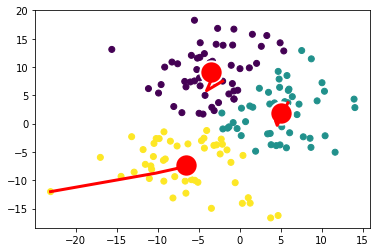

In [4]:
_ = plt.scatter(X[:, 0], X[:, 1], c=cluster_label)
_ = plt.scatter(new_centroids[:,0], new_centroids[:,1], marker='o', s=500, c='r', edgecolors='w', linewidths=2)

plt.plot(np.array(positions)[:,0,0],np.array(positions)[:,0,1],'r',linewidth=3)
plt.plot(np.array(positions)[:,1,0],np.array(positions)[:,1,1],'r',linewidth=3)
plt.plot(np.array(positions)[:,2,0],np.array(positions)[:,2,1],'r',linewidth=3)

## Pen and Paper

Consider a set P of points as shown below:  
<img src="ex2.png" width="400">

#### Question 2.1

Recall that the DBSCAN algorithm classifies each data point into one of 3 types: core ,  border , and  noise . The classification is based on two parameters, a distance  r and a threshold  t . Set  r = 1 and  t = 3. What are the types of a, b, c in the figure, respectively?  

**Answer**


Let **p** be a point in P. **p** is a core point if its neighborhood covers at least t points of P. On the other hand, **p** is a border point if it is not a core point, but falls in the neighborhood of a core point. Finally, **p** is a **noise** point if it is neither a core nor a border point.  

In our problem, point **a** is clearly a **core** point because the circle centered at a covers 4 (≥ 3) points. Point **b** is not a core point because its neighborhood as shown covers only 2 points. However, it is a **border** point because (i) point (6, 4) is a core point, and (ii) b is in the neighborhood of (6, 4). Finally, point **c** is a **noise** point

#### Question 2.2
Set  r  = 1 and   t  = 3, and consider the point set  P  in Question 2.  
1) Are points  d and  e  connected? If so, show that there is a point  p that can
reach both  d   and  e.  
2) How about points  f  and  g ?  

**Answer**

Point d is reachable from point a via sequence **a**,**(3, 6)**,**d** where both **a** and **(3, 6)** are core points. Similarly, **e** is reachable from a via sequence **a**,**(3, 8)**,**(4, 8)**,**e** where all points in the sequence except **e** are core points. Hence,  **d** and **e** are connected. **(3, 3)** is the only point that can reach **f**. However, **g** is not reachable from **(3, 3)**. Therefore, **f** and **g** are not connected.

#### Question 2.3  
Set  r  = 1 and  t  = 3. Show the output of DBSCAN on the point set  P in Question 2 (i.e., what are the points in each of the clusters returned?).

**Answer**

In the lecture, we have introduced an implementation of DBSCAN. Here, we describe another implementation which returns the same result (Page 182 of Data Mining: The Textbook by Charu C. Aggarwal).
The algorithm first classifies each point of P as a core, border, or noise point. Then, it discards the noise points. At this stage, the points remaining in P are as shown below, where the black (white) dots are core (border) points.

<img src="sol1.png" width="400">

Then, the algorithm temporarily ignores the border points, and draws an edge between each pair of core points that are within distance r = 1. This creates a graph:

<img src="sol2.png" width="400">

It proceeds by computing the connected components of the graph, where each connected component is a maximal set of vertices where each pair of vertices are connected by a path of edges. In the above example, there are 3 connected components: P1 = {a, b, c, d, e, f}, P2 = {g}, and P3 = {h, i, j}. P1, P2 and P3 form a cluster, respectively. In the final step, the algorithm assigns each border point z to each cluster that contains a core point whose neighborhood covers z. Consider, for example, point m. It is added to P1 because m is in the neighborhood of f. After assigning all the borderpoints, we get  
  
{a,b,c,d,e,f,k,m,o}  
{g,n,l}  
{h,i,j,p,q,r,s}  
  
as the final clusters.